In this notebook, we will try to detect anomalies in the Cloudwatch dataset.<br><br>
First we import our packages

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import kstest
from scipy.stats import normaltest

from sklearn.ensemble import IsolationForest

Now we read in our data

In [3]:
df = pd.read_csv('./Data/realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv', index_col = "timestamp", parse_dates = ['timestamp'])
print(df.head())

                     value
timestamp                 
2014-02-14 14:30:00  0.132
2014-02-14 14:35:00  0.134
2014-02-14 14:40:00  0.134
2014-02-14 14:45:00  0.134
2014-02-14 14:50:00  0.134


## Exploratory Analysis

Let's first observe the distribution of the data

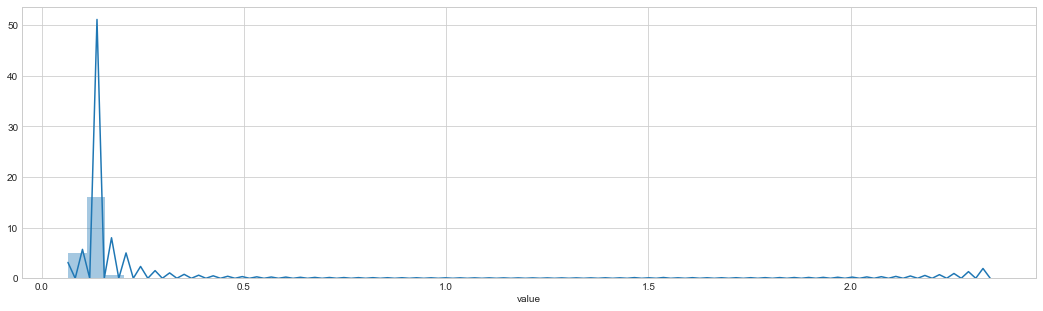

In [4]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = (40, 5))
plt.subplot(1, 2, 2)
sns.distplot(df['value']);

KstestResult(statistic=0.5263110872719229, pvalue=0.0)
NormaltestResult(statistic=7485.533791498338, pvalue=0.0)


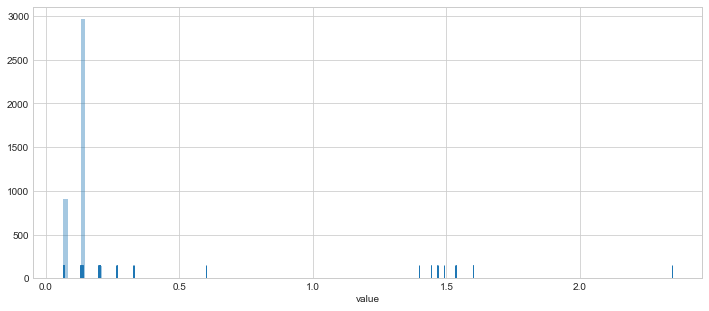

In [5]:
fig = plt.figure(figsize = (12, 5))
sns.distplot(df['value'], kde=False, rug=True, bins=140)

print(kstest(df["value"], 'norm'))
print(normaltest(df["value"], axis = None))

We can see that the data is not normal because the p value is 0.0 for both test results

Original Dataset: 
             value
count  4032.000000
mean      0.126303
std       0.094813
min       0.066000
25%       0.132000
50%       0.134000
75%       0.134000
max       2.344000 



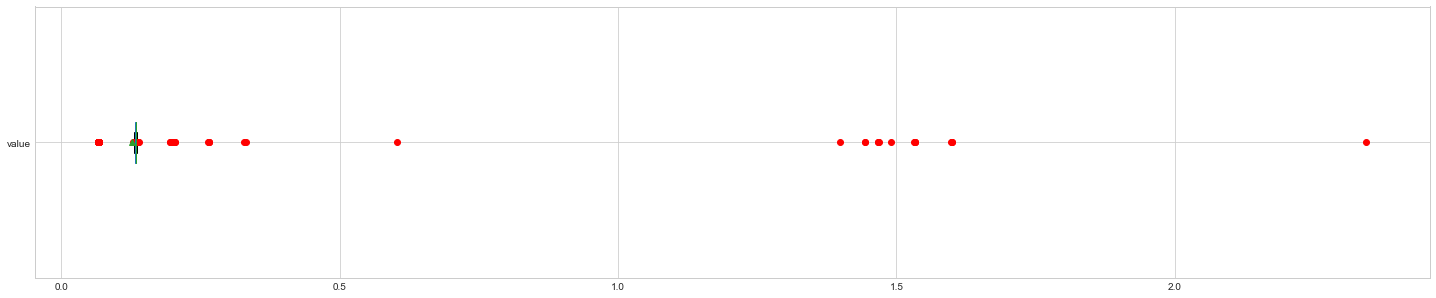

In [6]:
dfUnder = df[['value']]

dfValueStats = dfUnder.describe()
print("Original Dataset: ")
print(dfValueStats, "\n")

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = (25, 5)) 
dfUnder.boxplot(sym='r',vert=False,patch_artist=True,meanline=False,showmeans=True);

The box plot above makes sense because any amount of data can be sent in a five minute interval from 0B to infinity<br>
However, most of the volume occurs under value 0.25, so we will drop all data with a value over 0.25 <br>
This will also make the data more symmetric

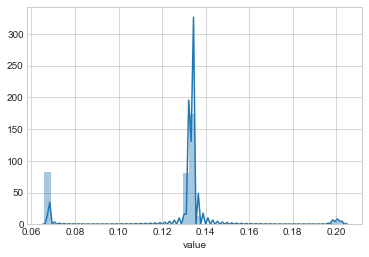

In [7]:
dfUnder = df.loc[df['value'] <= 0.25]

sns.distplot(dfUnder['value']);

In [8]:
print(dfUnder.count())
print(kstest(dfUnder["value"], 'norm'))
print(normaltest(dfUnder["value"], axis = None))

value    4010
dtype: int64
KstestResult(statistic=0.5263110872719229, pvalue=0.0)
NormaltestResult(statistic=183.65540637850526, pvalue=1.3174532678862003e-40)


We only cut off 22 values and the graph looks a bit more normal. The pvalue is bad and will lead to some false detections but it isn't 0, so we will try to apply 1 and 3 sigma anomaly detection. 

## Anomaly Detection

In [9]:
lower3Sigma = dfUnder.mean()-3*dfUnder.std()
upper3Sigma = dfUnder.mean()+3*dfUnder.std()

threeSigmaAnom = dfUnder[(dfUnder['value'] > upper3Sigma['value'])]
print("3 Sigma: ")
print('Number of Anomalies detected: ', threeSigmaAnom['value'].count(),"\n")
 


3 Sigma: 
Number of Anomalies detected:  0 



We see that the data is not normal enough. The result is a standard deviation that is too high to apply 3 sigma because when we do, it yields 0 anomalies.
<br>
Now let's try 1 sigma

1 Sigma: 
Number of Anomalies detected:  1046  ( 26.084788029925186 %)



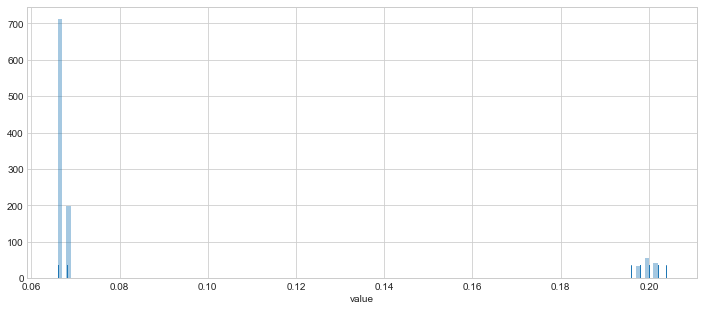

In [10]:
lower1Sigma = dfUnder.mean()-dfUnder.std()
upper1Sigma = dfUnder.mean()+dfUnder.std()

oneSigmaAnom = dfUnder[(dfUnder['value'] < lower1Sigma['value']) | (dfUnder['value'] > upper1Sigma['value'])]
print("1 Sigma: ")
print('Number of Anomalies detected: ', oneSigmaAnom['value'].count(), 
      ' (', 100*oneSigmaAnom['value'].count()/dfUnder['value'].count(), "%)\n")
 
fig = plt.figure(figsize = (12, 5))
sns.distplot(oneSigmaAnom['value'], kde=False, rug=True, bins=140);

Using 1 sigma, we detect 26% of the data are anomalies
<br>
This standard deviation seems a bit low, but makes sense since the graph is tall and skinny
<br><br>
Now we will try an isolation forest<br>
We need to parse the timestamp to make it usable by the iso forest

In [11]:
dfOriginal = df

df['Weekday'] = df.index.map(lambda s : s.weekday())
df['Time'] = df.index - df.index.map(lambda s : s.floor(freq ='D'))
df['Time'] = df.Time.map(lambda s : s.value/60/60/1000000000)

df.head()

,value,Weekday,Time
timestamp,,,
2014-02-14 14:30:00,0.132,4,14.500000
2014-02-14 14:35:00,0.134,4,14.583333
2014-02-14 14:40:00,0.134,4,14.666667
2014-02-14 14:45:00,0.134,4,14.750000
2014-02-14 14:50:00,0.134,4,14.833333


Now we applying the isolation forest to the data set

In [12]:
rng = np.random.RandomState(42)
ilf = IsolationForest(n_estimators = 100,
                      max_samples = 256,
                      behaviour = "new",
                      random_state = rng,
                      contamination = 0.03              
    )

X_cols = ['value', 'Weekday', 'Time']
ilf.fit(df[X_cols])

df['pred'] = ilf.predict(df[X_cols])
anom = df.loc[df['pred'] == -1]
anom.head()

,value,Weekday,Time,pred
timestamp,,,,
2014-02-14 23:55:00,0.200,4,23.916667,-1
2014-02-15 03:05:00,1.466,5,3.083333,-1
2014-02-15 05:55:00,0.200,5,5.916667,-1
2014-02-15 12:55:00,0.200,5,12.916667,-1
2014-02-16 00:20:00,0.068,6,0.333333,-1


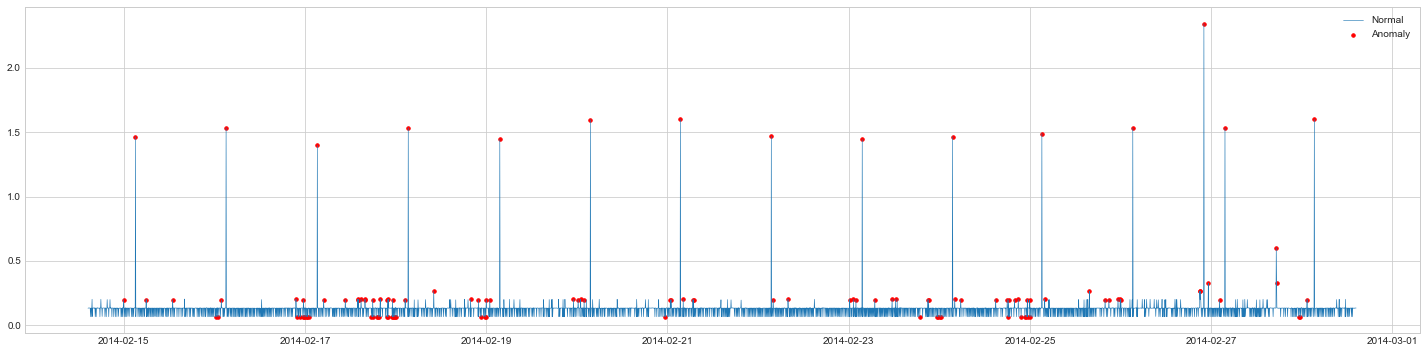

In [13]:
# visualize
fig, ax = plt.subplots(figsize=(25, 6))

a = df.loc[df['pred'] == -1, ['value']]

ax.plot(df.index, df['value'], label = 'Normal', linewidth=0.6)
ax.scatter(a.index, a['value'], s=12, color='red', label = 'Anomaly')

plt.legend()
plt.show();

The forest is providing good detection of abnormal spikes in CloudWatch usage<br><br>
And we can look at the volume of anomalies detected compared to the original data set

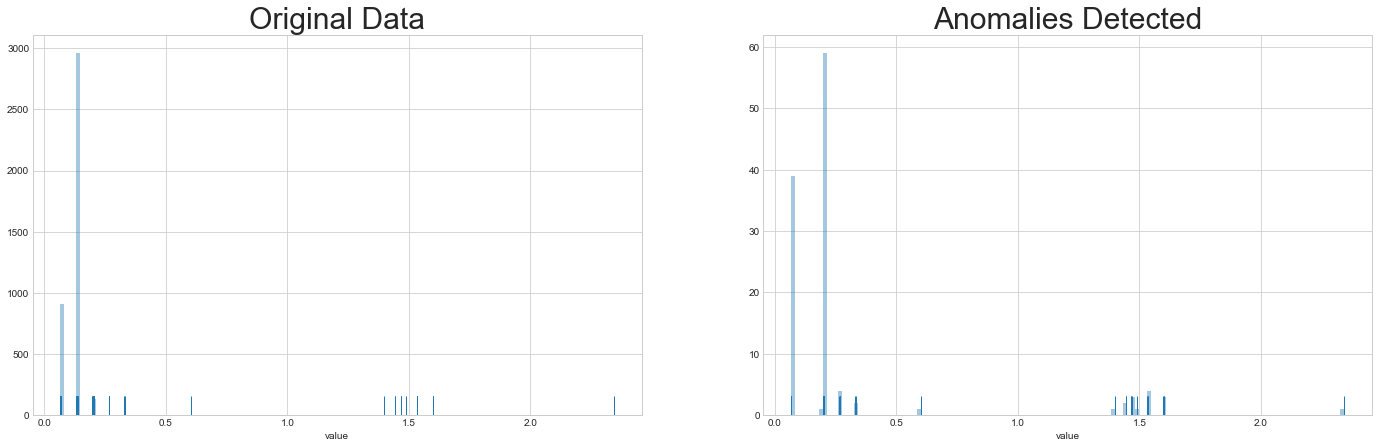

In [14]:
fig = plt.figure(figsize = (24, 7))

plt.subplot(1, 2, 1)
origPlot = sns.distplot(df['value'], kde=False, rug=True, bins=140)
origPlot.set_title('Original Data', fontsize=30)

plt.subplot(1, 2, 2)
anomPlot = sns.distplot(anom['value'], kde=False, rug=True, bins=140)
anomPlot.set_title('Anomalies Detected', fontsize=30);

In [15]:
print( anom['value'].count()/df['value'].count()*100, "%" )

3.0009920634920637 %


In [16]:
We see that the isolation forest detected a desirable amount of data and it performed well at (shown in visualization above) detecting abnormalities

SyntaxError: invalid syntax (<ipython-input-16-bd156be79d16>, line 1)